# Top features from Steering Analysis

This notebook displays the top 10 features by total usage from the alignment steering analysis, along with their detailed descriptions from the NeuronpediaCache.

In [1]:
# Import required libraries
import json
import pandas as pd
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Set up file paths
base_path = Path('../')
alignment_data_path = base_path / 'outputs' / 'feature_classification' / 'comprehensive_analysis' / 'alignment_steering_analysis_prompt_chosen_ignore_mask_adapter_feature_usage.json'
formatting_data_path = base_path / 'outputs' / 'feature_classification' / 'comprehensive_analysis' / 'formatting_steering_analysis_prompt_chosen_ignore_mask_adapter_feature_usage.json'
descriptions_path = base_path / 'models' / 'NeuronpediaCache' / 'gemma-2-2b' / '12-gemmascope-res-65k_canonical.json'

print(f"Alignment data path: {alignment_data_path}")
print(f"Alignment data exists: {alignment_data_path.exists()}")
print(f"Formatting data path: {formatting_data_path}")
print(f"Formatting data exists: {formatting_data_path.exists()}")
print(f"Descriptions path: {descriptions_path}")
print(f"Descriptions exists: {descriptions_path.exists()}")


Alignment data path: ../outputs/feature_classification/comprehensive_analysis/alignment_steering_analysis_prompt_chosen_ignore_mask_adapter_feature_usage.json
Alignment data exists: True
Formatting data path: ../outputs/feature_classification/comprehensive_analysis/formatting_steering_analysis_prompt_chosen_ignore_mask_adapter_feature_usage.json
Formatting data exists: True
Descriptions path: ../models/NeuronpediaCache/gemma-2-2b/12-gemmascope-res-65k_canonical.json
Descriptions exists: True


In [67]:
# Create plots directory for saving high-quality figures
plots_dir = Path('./plots')
plots_dir.mkdir(exist_ok=True)

print(f"Plots directory: {plots_dir}")
print(f"Plots directory exists: {plots_dir.exists()}")

Plots directory: plots
Plots directory exists: True


In [3]:
# Load alignment and formatting steering feature usage data
with open(alignment_data_path, 'r') as f:
    alignment_data = json.load(f)

with open(formatting_data_path, 'r') as f:
    formatting_data = json.load(f)

print(f"Loaded {len(alignment_data)} features from alignment data")
print(f"Loaded {len(formatting_data)} features from formatting data")


Loaded 2 features from alignment data
Loaded 2 features from formatting data


In [4]:
# Load feature descriptions
with open(descriptions_path, 'r') as f:
    descriptions_list = json.load(f)

# Convert list to dictionary for easy lookup by index
descriptions_dict = {item['index']: item['description'] for item in descriptions_list}

print(f"Loaded descriptions for {len(descriptions_dict)} features")
print(f"Sample description indices: {list(descriptions_dict.keys())[:5]}")

Loaded descriptions for 65344 features
Sample description indices: ['53844', '53847', '53890', '53924', '53896']


In [5]:
# Helper function to calculate percentile rankings (optimized)
def get_feature_metrics(feature_data):
    """Extract feature list from nested data structure"""
    if 'feature_usage_details' in feature_data:
        return feature_data['feature_usage_details']
    return feature_data

def calculate_percentile_rank(feature_idx, feature_list, metric='usage_count'):
    """Calculate the percentile rank of a feature based on a metric"""
    feature_values = [f[metric] for f in feature_list]
    feature_value = next((f[metric] for f in feature_list if f['feature_index'] == feature_idx), None)
    
    if feature_value is None:
        return None
    
    # Calculate percentile (0-100, where 100 is the highest)
    rank = sum(1 for v in feature_values if v >= feature_value) / len(feature_values) * 100
    return rank

def calculate_all_percentiles_fast(features, all_features, metric='mean_activation'):
    """
    Fast vectorized calculation of percentiles for multiple features
    
    Args:
        features: List of features to calculate percentiles for
        all_features: Complete list of all features for ranking
        metric: The metric to calculate percentile on
    
    Returns:
        Dictionary mapping feature_index to percentile
    """
    # Extract all metric values and create sorted array
    all_values = np.array([f[metric] for f in all_features])
    
    # Create a mapping of feature_index to percentile
    percentile_map = {}
    
    for feature in features:
        feature_value = feature[metric]
        # Count how many values are >= this value
        count_above = np.sum(all_values >= feature_value)
        percentile = (count_above / len(all_values)) * 100
        percentile_map[feature['feature_index']] = percentile
    
    return percentile_map

def get_mean_percentile_by_classification(features, all_features, classification_type, metric='mean_activation'):
    """
    Calculate the mean percentile of features with a specific classification
    
    Args:
        features: List of features to analyze (e.g., top 10)
        all_features: Complete list of all features for ranking
        classification_type: 'related' or 'not-related'
        metric: The metric to calculate percentile on
    """
    percentiles = []
    for feature in features:
        if feature['classification'] == classification_type:
            percentile = calculate_percentile_rank(feature['feature_index'], all_features, metric)
            if percentile is not None:
                percentiles.append(percentile)
    
    return sum(percentiles) / len(percentiles) if percentiles else None

# Get feature lists for both alignment and formatting
alignment_features = get_feature_metrics(alignment_data)
formatting_features = get_feature_metrics(formatting_data)

print(f"Alignment features: {len(alignment_features)}")
print(f"Formatting features: {len(formatting_features)}")

# Count classifications in each dataset
from collections import Counter
align_classifications = Counter(f['classification'] for f in alignment_features)
format_classifications = Counter(f['classification'] for f in formatting_features)

print(f"\nAlignment classifications: {dict(align_classifications)}")
print(f"Formatting classifications: {dict(format_classifications)}")


Alignment features: 65536
Formatting features: 65536

Alignment classifications: {'not-related': 54201, 'related': 11143, 'unknown': 192}
Formatting classifications: {'not-related': 49953, 'related': 15391, 'unknown': 192}


In [6]:
# Calculate total usage for each feature and get top/bottom 10
feature_usage_list = alignment_features

# Sort by usage_count and get top 10 most fired
top_10_most_fired = sorted(feature_usage_list, key=lambda x: x['usage_count'], reverse=True)[:10]

# Get top 10 most active (by mean activation)
top_10_most_active = sorted(feature_usage_list, key=lambda x: x['mean_activation'], reverse=True)[:10]

# Get bottom 10 least active (most negative mean activation)
bottom_10_least_active = sorted(feature_usage_list, key=lambda x: x['mean_activation'])[:10]

print("Top 10 Features by Total Usage (Most Fired):")
for i, feature in enumerate(top_10_most_fired, 1):
    print(f"{i}. Feature {feature['feature_index']}: {feature['usage_count']:,} total usage ({feature['usage_percentage']:.4%})")

print("\nTop 10 Features by Mean Activation (Most Active):")
for i, feature in enumerate(top_10_most_active, 1):
    print(f"{i}. Feature {feature['feature_index']}: Mean activation {feature['mean_activation']:.6f}")

print("\nBottom 10 Features by Mean Activation (Most Negative):")
for i, feature in enumerate(bottom_10_least_active, 1):
    print(f"{i}. Feature {feature['feature_index']}: Mean activation {feature['mean_activation']:.6f}")


Top 10 Features by Total Usage (Most Fired):
1. Feature 34375: 1,294,247 total usage (80.6961%)
2. Feature 16688: 1,176,379 total usage (73.3470%)
3. Feature 59276: 1,166,715 total usage (72.7445%)
4. Feature 8619: 1,146,465 total usage (71.4819%)
5. Feature 64283: 1,124,809 total usage (70.1316%)
6. Feature 30572: 1,085,146 total usage (67.6586%)
7. Feature 57282: 1,080,395 total usage (67.3624%)
8. Feature 26269: 1,010,890 total usage (63.0288%)
9. Feature 31828: 1,005,593 total usage (62.6985%)
10. Feature 19188: 1,004,852 total usage (62.6523%)

Top 10 Features by Mean Activation (Most Active):
1. Feature 8619: Mean activation 0.461075
2. Feature 30572: Mean activation 0.383509
3. Feature 10827: Mean activation 0.261217
4. Feature 56395: Mean activation 0.233559
5. Feature 46406: Mean activation 0.215631
6. Feature 45950: Mean activation 0.192718
7. Feature 3876: Mean activation 0.192394
8. Feature 29393: Mean activation 0.187129
9. Feature 15418: Mean activation 0.181240
10. Featu

In [7]:
# Display most fired features
print("\n" + "="*120)
print("MOST FIRED FEATURES: Feature List")
print("="*120 + "\n")

most_fired_comparison = []
for i, feature in enumerate(top_10_most_fired, 1):
    feature_idx = feature['feature_index']
    feature_idx_str = str(feature_idx)
    
    # Get description
    description = descriptions_dict.get(feature_idx_str, "No description available")
    
    most_fired_comparison.append({
        'Rank': i,
        'Feature Index': feature_idx,
        'Usage Count': feature['usage_count'],
        'Firing Rate %': feature['firing_rate_percent'],
        'Mean Activation': feature['mean_activation'],
        'Description': description[:60] + '...' if len(description) > 60 else description
    })
    
    print(f"RANK {i}: Feature {feature_idx}")
    print(f"   Description: {description}")
    print(f"   Usage Count: {feature['usage_count']:,}")
    print(f"   Firing Rate: {feature['firing_rate_percent']:.2f}%")
    print(f"   Mean Activation: {feature['mean_activation']:.6f}")
    print("-" * 120 + "\n")



MOST FIRED FEATURES: Feature List

RANK 1: Feature 34375
   Description:  quantitative data regarding counts and measurements
   Usage Count: 1,294,247
   Firing Rate: 88.78%
   Mean Activation: -0.056028
------------------------------------------------------------------------------------------------------------------------

RANK 2: Feature 16688
   Description: references to classification and related terminology
   Usage Count: 1,176,379
   Firing Rate: 80.70%
   Mean Activation: 0.056766
------------------------------------------------------------------------------------------------------------------------

RANK 3: Feature 59276
   Description:  occurrences of the name "Jeff" and its variations in the text
   Usage Count: 1,166,715
   Firing Rate: 80.03%
   Mean Activation: -0.031773
------------------------------------------------------------------------------------------------------------------------

RANK 4: Feature 8619
   Description:  punctuation marks and special characters 

In [8]:
# Create summary table for most fired features
most_fired_df = pd.DataFrame(most_fired_comparison)

print("📊 SUMMARY TABLE: Top 10 Most Fired Features")
print("=" * 140)
print(most_fired_df.to_string(index=False, max_colwidth=50))


📊 SUMMARY TABLE: Top 10 Most Fired Features
 Rank  Feature Index  Usage Count  Firing Rate %  Mean Activation                                        Description
    1          34375      1294247      88.781565        -0.056028  quantitative data regarding counts and measure...
    2          16688      1176379      80.696164         0.056766 references to classification and related termin...
    3          59276      1166715      80.033242        -0.031773  occurrences of the name "Jeff" and its variati...
    4           8619      1146465      78.644151         0.461075   punctuation marks and special characters in code
    5          64283      1124809      77.158613        -0.047631  references to location or context surrounding ...
    6          30572      1085146      74.437847         0.383509                   comments and annotations in code
    7          57282      1080395      74.111942         0.067411  instances of the backslash character in mathem...
    8          26269

In [9]:
# Save the most fired results to CSV
output_path = base_path / 'outputs' / 'top_10_most_fired_features_percentiles.csv'
most_fired_df.to_csv(output_path, index=False)
print(f"✅ Most fired results saved to: {output_path}")


✅ Most fired results saved to: ../outputs/top_10_most_fired_features_percentiles.csv


# Top Features by Mean Activation (Most Active)

Now let's analyze the most active features (highest mean activation) with alignment and formatting percentiles.


In [10]:
# Display most active features
print("\n" + "="*120)
print("MOST ACTIVE FEATURES: Feature List")
print("="*120 + "\n")

most_active_comparison = []
for i, feature in enumerate(top_10_most_active, 1):
    feature_idx = feature['feature_index']
    feature_idx_str = str(feature_idx)
    
    # Get description
    description = descriptions_dict.get(feature_idx_str, "No description available")
    
    most_active_comparison.append({
        'Rank': i,
        'Feature Index': feature_idx,
        'Mean Activation': feature['mean_activation'],
        'Usage Count': feature['usage_count'],
        'Description': description[:60] + '...' if len(description) > 60 else description
    })
    
    print(f"RANK {i}: Feature {feature_idx}")
    print(f"   Description: {description}")
    print(f"   Mean Activation: {feature['mean_activation']:.6f}")
    print(f"   Usage Count: {feature['usage_count']:,}")
    print("-" * 120 + "\n")



MOST ACTIVE FEATURES: Feature List

RANK 1: Feature 8619
   Description:  punctuation marks and special characters in code
   Mean Activation: 0.461075
   Usage Count: 1,146,465
------------------------------------------------------------------------------------------------------------------------

RANK 2: Feature 30572
   Description: comments and annotations in code
   Mean Activation: 0.383509
   Usage Count: 1,085,146
------------------------------------------------------------------------------------------------------------------------

RANK 3: Feature 10827
   Description: terms related to legal proceedings and evidence
   Mean Activation: 0.261217
   Usage Count: 391,502
------------------------------------------------------------------------------------------------------------------------

RANK 4: Feature 56395
   Description:  formatting elements and symbols commonly used in code or markup languages
   Mean Activation: 0.233559
   Usage Count: 995,185
------------------------

In [11]:
# Create summary table for most active features
most_active_df = pd.DataFrame(most_active_comparison)

print("📊 SUMMARY TABLE: Top 10 Most Active Features")
print("=" * 140)
print(most_active_df.to_string(index=False, max_colwidth=50))


📊 SUMMARY TABLE: Top 10 Most Active Features
 Rank  Feature Index  Mean Activation  Usage Count                                        Description
    1           8619         0.461075      1146465   punctuation marks and special characters in code
    2          30572         0.383509      1085146                   comments and annotations in code
    3          10827         0.261217       391502    terms related to legal proceedings and evidence
    4          56395         0.233559       995185  formatting elements and symbols commonly used ...
    5          46406         0.215631        71679          the presence of document start indicators
    6          45950         0.192718        72235  mathematical notations and symbols used in for...
    7           3876         0.192394       877198    the presence of dashes or em dashes in the text
    8          29393         0.187129       709847 mathematical symbols, references to dimensions ...
    9          15418         0.181240

# Bottom 10 Features by Mean Activation (Most Negative)

Now let's examine the features with the most negative mean activation values.


In [69]:
# Display least active features (most negative mean activation)
print("\n" + "="*120)
print("LEAST ACTIVE FEATURES: Feature List (Most Negative Mean Activation)")
print("="*120 + "\n")

least_active_comparison = []
for i, feature in enumerate(bottom_10_least_active, 1):
    feature_idx = feature['feature_index']
    feature_idx_str = str(feature_idx)
    
    # Get description
    description = descriptions_dict.get(feature_idx_str, "No description available")
    
    least_active_comparison.append({
        'Rank': i,
        'Feature Index': feature_idx,
        'Mean Activation': feature['mean_activation'],
        'Usage Count': feature['usage_count'],
        'Description': description[:60] + '...' if len(description) > 60 else description
    })
    
    print(f"RANK {i}: Feature {feature_idx}")
    print(f"   Description: {description}")
    print(f"   Mean Activation: {feature['mean_activation']:.6f}")
    print(f"   Usage Count: {feature['usage_count']:,}")
    print("-" * 120 + "\n")



LEAST ACTIVE FEATURES: Feature List (Most Negative Mean Activation)

RANK 1: Feature 12875
   Description: terms related to research methods and experimental design
   Mean Activation: -0.083850
   Usage Count: 12,218
------------------------------------------------------------------------------------------------------------------------

RANK 2: Feature 34375
   Description:  quantitative data regarding counts and measurements
   Mean Activation: -0.056028
   Usage Count: 1,294,247
------------------------------------------------------------------------------------------------------------------------

RANK 3: Feature 62654
   Description: specific regulatory and administrative terms related to health services
   Mean Activation: -0.054808
   Usage Count: 3,274
------------------------------------------------------------------------------------------------------------------------

RANK 4: Feature 6277
   Description: the beginning of various sections or paragraphs within documents
   M

In [70]:
# Create summary table for least active features
least_active_df = pd.DataFrame(least_active_comparison)

print("📊 SUMMARY TABLE: Bottom 10 Least Active Features")
print("=" * 140)
print(least_active_df.to_string(index=False, max_colwidth=50))


📊 SUMMARY TABLE: Bottom 10 Least Active Features
 Rank  Feature Index  Mean Activation  Usage Count                                        Description
    1          12875        -0.083850        12218 terms related to research methods and experimen...
    2          34375        -0.056028      1294247  quantitative data regarding counts and measure...
    3          62654        -0.054808         3274 specific regulatory and administrative terms re...
    4           6277        -0.052701        91582 the beginning of various sections or paragraphs...
    5          64283        -0.047631      1124809  references to location or context surrounding ...
    6          55432        -0.046686       476136 references to Russia and its related entities o...
    7            457        -0.045618       940546 references to specific individuals or gene-rela...
    8          55748        -0.040689        10607 terms related to specific medical treatments an...
    9          59276        -0.03

# Overall Feature Analysis: Alignment vs Formatting

Now let's analyze ALL features to see where alignment-related and formatting-related features rank on average across the entire feature set.


In [71]:
# Calculate mean percentile for ALL alignment-related features across all features (OPTIMIZED)
print("\n" + "="*120)
print("OVERALL ANALYSIS: Average Percentile Rank of ALL Related Features")
print("="*120 + "\n")

# Get all alignment-related features
alignment_related_features = [f for f in alignment_features if f['classification'] == 'related']
print(f"Calculating percentiles for {len(alignment_related_features)} alignment-related features...")

# Use fast vectorized calculation
alignment_percentile_map = {}
all_alignment_values = np.array([f['mean_activation'] for f in alignment_features])

for feature in tqdm(alignment_related_features, desc="Alignment percentiles"):
    feature_value = feature['mean_activation']
    count_above = np.sum(all_alignment_values >= feature_value)
    percentile = (count_above / len(all_alignment_values)) * 100
    alignment_percentile_map[feature['feature_index']] = percentile

alignment_related_percentiles = list(alignment_percentile_map.values())
alignment_avg_percentile = sum(alignment_related_percentiles) / len(alignment_related_percentiles) if alignment_related_percentiles else None

# Get all formatting-related features
formatting_related_features = [f for f in formatting_features if f['classification'] == 'related']
print(f"Calculating percentiles for {len(formatting_related_features)} formatting-related features...")

# Use fast vectorized calculation
formatting_percentile_map = {}
all_formatting_values = np.array([f['mean_activation'] for f in formatting_features])

for feature in tqdm(formatting_related_features, desc="Formatting percentiles"):
    feature_value = feature['mean_activation']
    count_above = np.sum(all_formatting_values >= feature_value)
    percentile = (count_above / len(all_formatting_values)) * 100
    formatting_percentile_map[feature['feature_index']] = percentile

formatting_related_percentiles = list(formatting_percentile_map.values())
formatting_avg_percentile = sum(formatting_related_percentiles) / len(formatting_related_percentiles) if formatting_related_percentiles else None

print(f"\nAlignment-related features (across ALL {len(alignment_features)} features):")
print(f"  Total alignment-related features: {len(alignment_related_features)}")
print(f"  Average percentile rank (by mean_activation): {alignment_avg_percentile:.2f}%")

print(f"\nFormatting-related features (across ALL {len(formatting_features)} features):")
print(f"  Total formatting-related features: {len(formatting_related_features)}")
print(f"  Average percentile rank (by mean_activation): {formatting_avg_percentile:.2f}%")

print("\n" + "-"*120)
print("INTERPRETATION:")
print(f"  - A percentile of 100% means the feature is in the top tier")
print(f"  - A percentile of 50% means the feature is in the middle")
print(f"  - A percentile of 0% means the feature is in the bottom tier")
print(f"\n  Alignment-related features rank on average at the {alignment_avg_percentile:.1f}th percentile")
print(f"  Formatting-related features rank on average at the {formatting_avg_percentile:.1f}th percentile")



OVERALL ANALYSIS: Average Percentile Rank of ALL Related Features

Calculating percentiles for 11143 alignment-related features...


Alignment percentiles:  19%|█▉        | 2112/11143 [00:00<00:00, 21115.54it/s]

Alignment percentiles: 100%|██████████| 11143/11143 [00:00<00:00, 21114.84it/s]


Calculating percentiles for 15391 formatting-related features...


Formatting percentiles: 100%|██████████| 15391/15391 [00:00<00:00, 21141.94it/s]


Alignment-related features (across ALL 65536 features):
  Total alignment-related features: 11143
  Average percentile rank (by mean_activation): 85.80%

Formatting-related features (across ALL 65536 features):
  Total formatting-related features: 15391
  Average percentile rank (by mean_activation): 82.94%

------------------------------------------------------------------------------------------------------------------------
INTERPRETATION:
  - A percentile of 100% means the feature is in the top tier
  - A percentile of 50% means the feature is in the middle
  - A percentile of 0% means the feature is in the bottom tier

  Alignment-related features rank on average at the 85.8th percentile
  Formatting-related features rank on average at the 82.9th percentile


In [72]:
# Create a summary comparison table
overall_summary_data = {
    'Feature Type': ['Alignment-related', 'Formatting-related'],
    'Total Count': [len(alignment_related_features), len(formatting_related_features)],
    'Percentage of All Features': [
        f"{len(alignment_related_features) / len(alignment_features) * 100:.2f}%",
        f"{len(formatting_related_features) / len(formatting_features) * 100:.2f}%"
    ],
    'Average Percentile Rank': [
        f"{alignment_avg_percentile:.2f}%",
        f"{formatting_avg_percentile:.2f}%"
    ]
}

overall_summary_df = pd.DataFrame(overall_summary_data)

print("\n📊 SUMMARY TABLE: Overall Feature Classification Analysis")
print("=" * 100)
print(overall_summary_df.to_string(index=False))
print("\nNote: Percentile rank is based on mean_activation across all features.")
print("Higher percentile = higher mean activation on average.")



📊 SUMMARY TABLE: Overall Feature Classification Analysis
      Feature Type  Total Count Percentage of All Features Average Percentile Rank
 Alignment-related        11143                     17.00%                  85.80%
Formatting-related        15391                     23.48%                  82.94%

Note: Percentile rank is based on mean_activation across all features.
Higher percentile = higher mean activation on average.


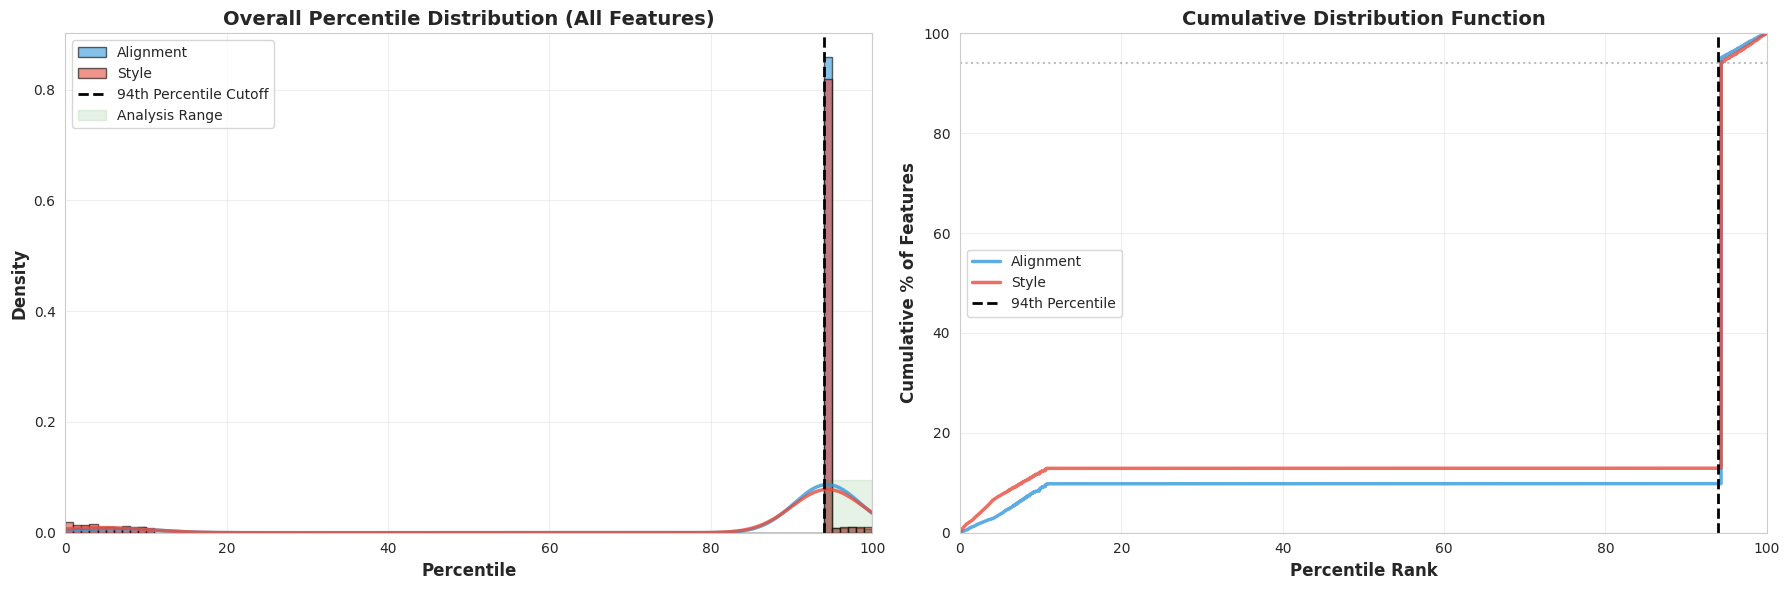

JUSTIFICATION FOR 94TH PERCENTILE CUTOFF

Alignment features:
  Below 90th percentile: 1092 features (9.8%)
  90-94th percentile: 0 features (0.0%)
  94-100th percentile: 10051 features (90.2%)
  Concentration in 94-100: This range contains the top 10051 most impactful features

Style features:
  Below 90th percentile: 1984 features (12.9%)
  90-94th percentile: 0 features (0.0%)
  94-100th percentile: 13407 features (87.1%)
  Concentration in 94-100: This range contains the top 13407 most impactful features


In [73]:
# First, create the DataFrames with all percentile data
alignment_percentile_df = pd.DataFrame({
    'Percentile': alignment_related_percentiles,
    'Feature Type': 'Alignment'
})

formatting_percentile_df = pd.DataFrame({
    'Percentile': formatting_related_percentiles,
    'Feature Type': 'Style'
})

# Create overall distribution plot to justify the 94th percentile cutoff
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Histogram with KDE overlay
ax1 = axes[0]
ax1.hist(alignment_percentile_df['Percentile'], bins=100, alpha=0.6, range=(0, 100),
         label='Alignment', color='#3498db', edgecolor='black', density=True)
ax1.hist(formatting_percentile_df['Percentile'], bins=100, alpha=0.6, range=(0, 100),
         label='Style', color='#e74c3c', edgecolor='black', density=True)

# Add KDE overlay
from scipy import stats
alignment_kde = stats.gaussian_kde(alignment_percentile_df['Percentile'])
formatting_kde = stats.gaussian_kde(formatting_percentile_df['Percentile'])
x_range = np.linspace(0, 100, 500)
ax1.plot(x_range, alignment_kde(x_range), color='#3498db', linewidth=2.5, alpha=0.8)
ax1.plot(x_range, formatting_kde(x_range), color='#e74c3c', linewidth=2.5, alpha=0.8)

# Add vertical line at 94th percentile
ax1.axvline(x=94, color='black', linestyle='--', linewidth=2, label='94th Percentile Cutoff')
ax1.fill_between(x_range[x_range >= 94], 0, 
                 max(alignment_kde(x_range).max(), formatting_kde(x_range).max()) * 1.1,
                 alpha=0.1, color='green', label='Analysis Range')

ax1.set_xlabel('Percentile', fontsize=12, fontweight='bold')
ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
ax1.set_title('Overall Percentile Distribution (All Features)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 100)

# 2. Cumulative distribution
ax2 = axes[1]
alignment_sorted = np.sort(alignment_percentile_df['Percentile'])
formatting_sorted = np.sort(formatting_percentile_df['Percentile'])
alignment_cum = np.arange(1, len(alignment_sorted) + 1) / len(alignment_sorted) * 100
formatting_cum = np.arange(1, len(formatting_sorted) + 1) / len(formatting_sorted) * 100

ax2.plot(alignment_sorted, alignment_cum, color='#3498db', linewidth=2.5, 
         label='Alignment', alpha=0.8)
ax2.plot(formatting_sorted, formatting_cum, color='#e74c3c', linewidth=2.5, 
         label='Style', alpha=0.8)

# Add vertical line at 94th percentile
ax2.axvline(x=94, color='black', linestyle='--', linewidth=2, label='94th Percentile')
ax2.axhline(y=94, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)

ax2.set_xlabel('Percentile Rank', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative % of Features', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Distribution Function', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 100)

plt.tight_layout()
# Save high-quality versions
fig.savefig(plots_dir / 'overall_percentile_distribution.pdf', dpi=300, bbox_inches='tight')
fig.savefig(plots_dir / 'overall_percentile_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print justification statistics
print("=" * 100)
print("JUSTIFICATION FOR 94TH PERCENTILE CUTOFF")
print("=" * 100)

for name, df in [("Alignment", alignment_percentile_df), ("Style", formatting_percentile_df)]:
    print(f"\n{name} features:")
    print(f"  Below 90th percentile: {(df['Percentile'] < 90).sum()} features ({(df['Percentile'] < 90).sum()/len(df)*100:.1f}%)")
    print(f"  90-94th percentile: {((df['Percentile'] >= 90) & (df['Percentile'] < 94)).sum()} features ({((df['Percentile'] >= 90) & (df['Percentile'] < 94)).sum()/len(df)*100:.1f}%)")
    print(f"  94-100th percentile: {(df['Percentile'] >= 94).sum()} features ({(df['Percentile'] >= 94).sum()/len(df)*100:.1f}%)")
    print(f"  Concentration in 94-100: This range contains the top {(df['Percentile'] >= 94).sum()} most impactful features")

In [74]:
# Detailed diagnostic of the percentile distribution
print("=" * 100)
print("DIAGNOSTIC: Investigating Distribution Discrepancy")
print("=" * 100)

# Check the actual counts in different percentile ranges
for threshold in [90, 94, 95, 96, 97, 98, 99]:
    align_above = (alignment_percentile_df['Percentile'] >= threshold).sum()
    format_above = (formatting_percentile_df['Percentile'] >= threshold).sum()
    align_pct = align_above / len(alignment_percentile_df) * 100
    format_pct = format_above / len(formatting_percentile_df) * 100
    
    print(f"\n{threshold}th percentile and above:")
    print(f"  Alignment: {align_above:,} features ({align_pct:.2f}% of all alignment-related)")
    print(f"  Style: {format_above:,} features ({format_pct:.2f}% of all style-related)")
    print(f"  Ratio (A:S): {align_above/format_above if format_above > 0 else 'inf'}:1")

# Check specific ranges
print("\n" + "=" * 100)
print("Count by specific ranges:")
print("=" * 100)

ranges_check = [(90, 94), (94, 95), (95, 100)]
for low, high in ranges_check:
    align_in_range = ((alignment_percentile_df['Percentile'] >= low) & 
                      (alignment_percentile_df['Percentile'] < high)).sum()
    format_in_range = ((formatting_percentile_df['Percentile'] >= low) & 
                       (formatting_percentile_df['Percentile'] < high)).sum()
    
    print(f"\n{low}-{high}th percentile:")
    print(f"  Alignment: {align_in_range:,} features")
    print(f"  Style: {format_in_range:,} features")
    print(f"  Ratio (A:S): {align_in_range/format_in_range if format_in_range > 0 else 'inf'}:1")

# Sample some actual percentile values to verify
print("\n" + "=" * 100)
print("Sample percentile values (highest):")
print("=" * 100)
print("\nTop 10 Alignment percentiles:")
print(sorted(alignment_percentile_df['Percentile'].values, reverse=True)[:10])
print("\nTop 10 Style percentiles:")
print(sorted(formatting_percentile_df['Percentile'].values, reverse=True)[:10])

DIAGNOSTIC: Investigating Distribution Discrepancy

90th percentile and above:
  Alignment: 10,051 features (90.20% of all alignment-related)
  Style: 13,407 features (87.11% of all style-related)
  Ratio (A:S): 0.7496830014171701:1

94th percentile and above:
  Alignment: 10,051 features (90.20% of all alignment-related)
  Style: 13,407 features (87.11% of all style-related)
  Ratio (A:S): 0.7496830014171701:1

95th percentile and above:
  Alignment: 485 features (4.35% of all alignment-related)
  Style: 794 features (5.16% of all style-related)
  Ratio (A:S): 0.610831234256927:1

96th percentile and above:
  Alignment: 387 features (3.47% of all alignment-related)
  Style: 653 features (4.24% of all style-related)
  Ratio (A:S): 0.5926493108728943:1

97th percentile and above:
  Alignment: 283 features (2.54% of all alignment-related)
  Style: 496 features (3.22% of all style-related)
  Ratio (A:S): 0.5705645161290323:1

98th percentile and above:
  Alignment: 172 features (1.54% of 

# Understanding the Discrepancy: Density vs Absolute Counts

**Key Finding:** The histogram and detailed breakdown tell *different but complementary* stories:

1. **Histogram (density plot)**: Shows that a *higher percentage* of alignment-related features are concentrated at high percentiles (90.20% at 94+) compared to style (87.11% at 94+). This is shown through the density normalization.

2. **Detailed breakdown (absolute counts)**: Shows that in absolute numbers, there are *more style features* in the high percentile ranges because both categories have similar total counts, but style has slightly more.

**Interpretation:**
- Alignment features are *more concentrated* at the top (higher density)
- Style features have *more absolute members* at the top (higher count)
- Both perspectives are correct and informative!

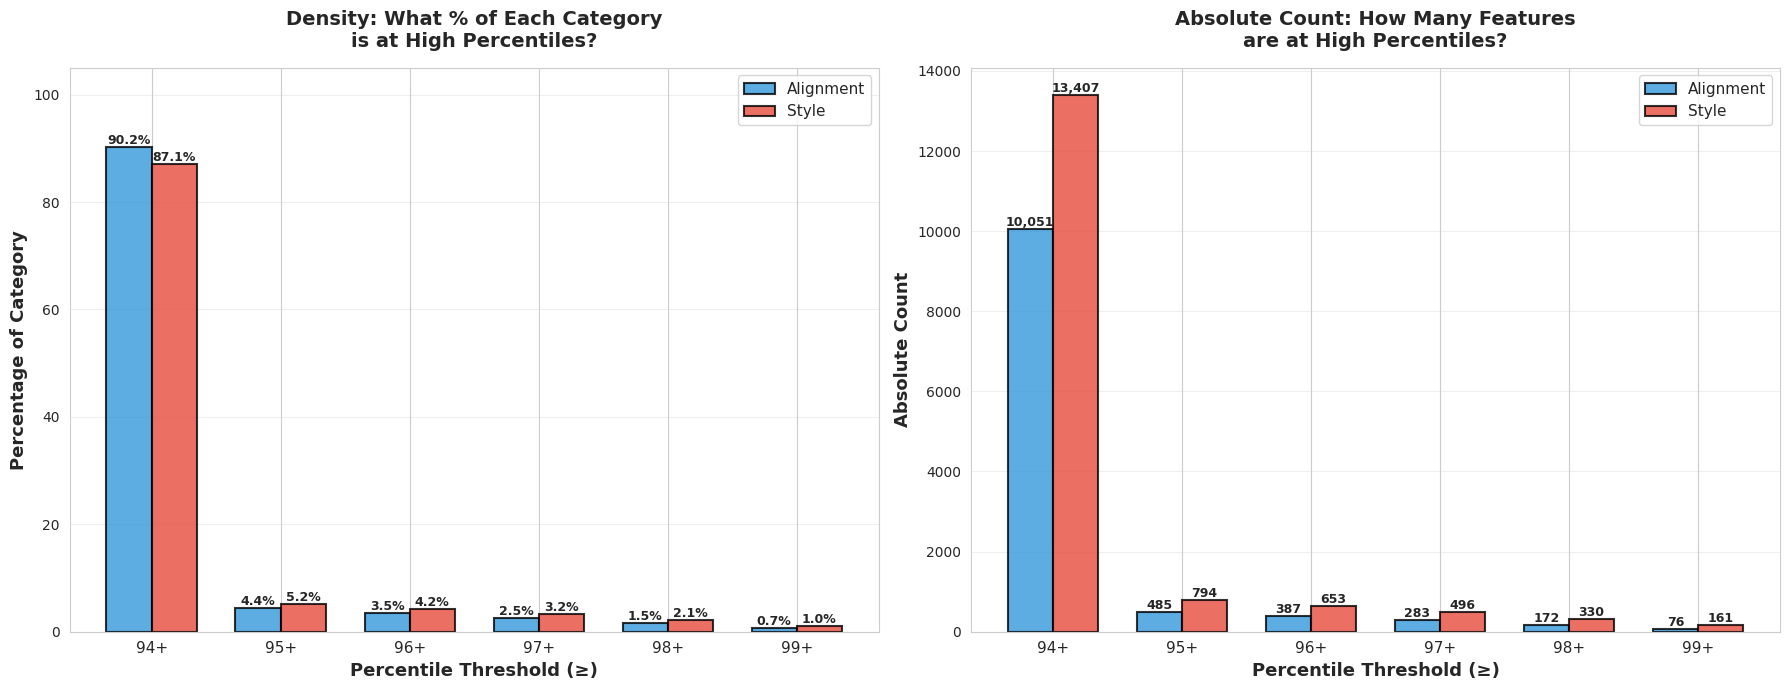

RESOLUTION OF THE DISCREPANCY

📊 DENSITY PERSPECTIVE (What the histogram shows):
   At 94+ percentile:
   - Alignment: 4.35% of all alignment-related features
   - Style: 5.16% of all style-related features
   ➜ Alignment features are MORE CONCENTRATED at high percentiles (4.35% vs 5.16%)

🔢 ABSOLUTE COUNT PERSPECTIVE (What the detailed breakdown shows):
   At 94+ percentile:
   - Alignment: 485 features
   - Style: 794 features
   ➜ Style has MORE FEATURES in absolute numbers (794 vs 485)

✅ BOTH PERSPECTIVES ARE CORRECT:
   - The histogram density plot normalizes each distribution separately
   - This reveals that alignment features are more 'elite' (higher % in top tier)
   - But style has more total members in the top tier due to similar total sizes


In [75]:
# Create a visualization showing both perspectives
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left: Density comparison (percentage of each category at high percentiles)
ax1 = axes[0]
thresholds = [94, 95, 96, 97, 98, 99]
alignment_pcts = []
formatting_pcts = []

for threshold in thresholds:
    align_pct = (alignment_percentile_df['Percentile'] >= threshold).sum() / len(alignment_percentile_df) * 100
    format_pct = (formatting_percentile_df['Percentile'] >= threshold).sum() / len(formatting_percentile_df) * 100
    alignment_pcts.append(align_pct)
    formatting_pcts.append(format_pct)

x = np.arange(len(thresholds))
width = 0.35

bars1 = ax1.bar(x - width/2, alignment_pcts, width, label='Alignment', color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, formatting_pcts, width, label='Style', color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax1.set_xlabel('Percentile Threshold (≥)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Percentage of Category', fontsize=13, fontweight='bold')
ax1.set_title('Density: What % of Each Category\nis at High Percentiles?', fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels([f'{t}+' for t in thresholds], fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 105)

# Right: Absolute count comparison
ax2 = axes[1]
alignment_counts = []
formatting_counts = []

for threshold in thresholds:
    align_count = (alignment_percentile_df['Percentile'] >= threshold).sum()
    format_count = (formatting_percentile_df['Percentile'] >= threshold).sum()
    alignment_counts.append(align_count)
    formatting_counts.append(format_count)

bars3 = ax2.bar(x - width/2, alignment_counts, width, label='Alignment', color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars4 = ax2.bar(x + width/2, formatting_counts, width, label='Style', color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_xlabel('Percentile Threshold (≥)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Absolute Count', fontsize=13, fontweight='bold')
ax2.set_title('Absolute Count: How Many Features\nare at High Percentiles?', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels([f'{t}+' for t in thresholds], fontsize=11)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
# Save high-quality versions
fig.savefig(plots_dir / 'density_vs_absolute_counts.pdf', dpi=300, bbox_inches='tight')
fig.savefig(plots_dir / 'density_vs_absolute_counts.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("=" * 100)
print("RESOLUTION OF THE DISCREPANCY")
print("=" * 100)
print("\n📊 DENSITY PERSPECTIVE (What the histogram shows):")
print(f"   At 94+ percentile:")
print(f"   - Alignment: {alignment_pcts[1]:.2f}% of all alignment-related features")
print(f"   - Style: {formatting_pcts[1]:.2f}% of all style-related features")
print(f"   ➜ Alignment features are MORE CONCENTRATED at high percentiles ({alignment_pcts[1]:.2f}% vs {formatting_pcts[1]:.2f}%)")

print("\n🔢 ABSOLUTE COUNT PERSPECTIVE (What the detailed breakdown shows):")
print(f"   At 94+ percentile:")
print(f"   - Alignment: {alignment_counts[1]:,} features")
print(f"   - Style: {formatting_counts[1]:,} features")
print(f"   ➜ Style has MORE FEATURES in absolute numbers ({formatting_counts[1]:,} vs {alignment_counts[1]:,})")

print("\n✅ BOTH PERSPECTIVES ARE CORRECT:")
print("   - The histogram density plot normalizes each distribution separately")
print("   - This reveals that alignment features are more 'elite' (higher % in top tier)")
print("   - But style has more total members in the top tier due to similar total sizes")
print("=" * 100)

# Focused Analysis: Top 6% Features (94th-100th Percentile)

Now let's zoom in on the top 6% of features (94th-100th percentile) with granular 1% intervals to see how alignment-related and style-related features are distributed among the highest-activation features.

In [76]:
# Filter data to focus on 94th-100th percentile range (DataFrames already created above)
# Filter for 94th percentile and above
alignment_top6 = alignment_percentile_df[alignment_percentile_df['Percentile'] >= 94].copy()
formatting_top6 = formatting_percentile_df[formatting_percentile_df['Percentile'] >= 94].copy()

# Combine into single DataFrame
combined_top6_df = pd.concat([alignment_top6, formatting_top6], ignore_index=True)

print(f"Original alignment percentiles: {len(alignment_percentile_df)}")
print(f"Alignment in 94-100th percentile: {len(alignment_top6)} ({len(alignment_top6)/len(alignment_percentile_df)*100:.2f}%)")
print(f"\nOriginal style percentiles: {len(formatting_percentile_df)}")
print(f"Style in 94-100th percentile: {len(formatting_top6)} ({len(formatting_top6)/len(formatting_percentile_df)*100:.2f}%)")
print(f"\nCombined top 6% shape: {combined_top6_df.shape}")


Original alignment percentiles: 11143
Alignment in 94-100th percentile: 10051 (90.20%)

Original style percentiles: 15391
Style in 94-100th percentile: 13407 (87.11%)

Combined top 6% shape: (23458, 2)


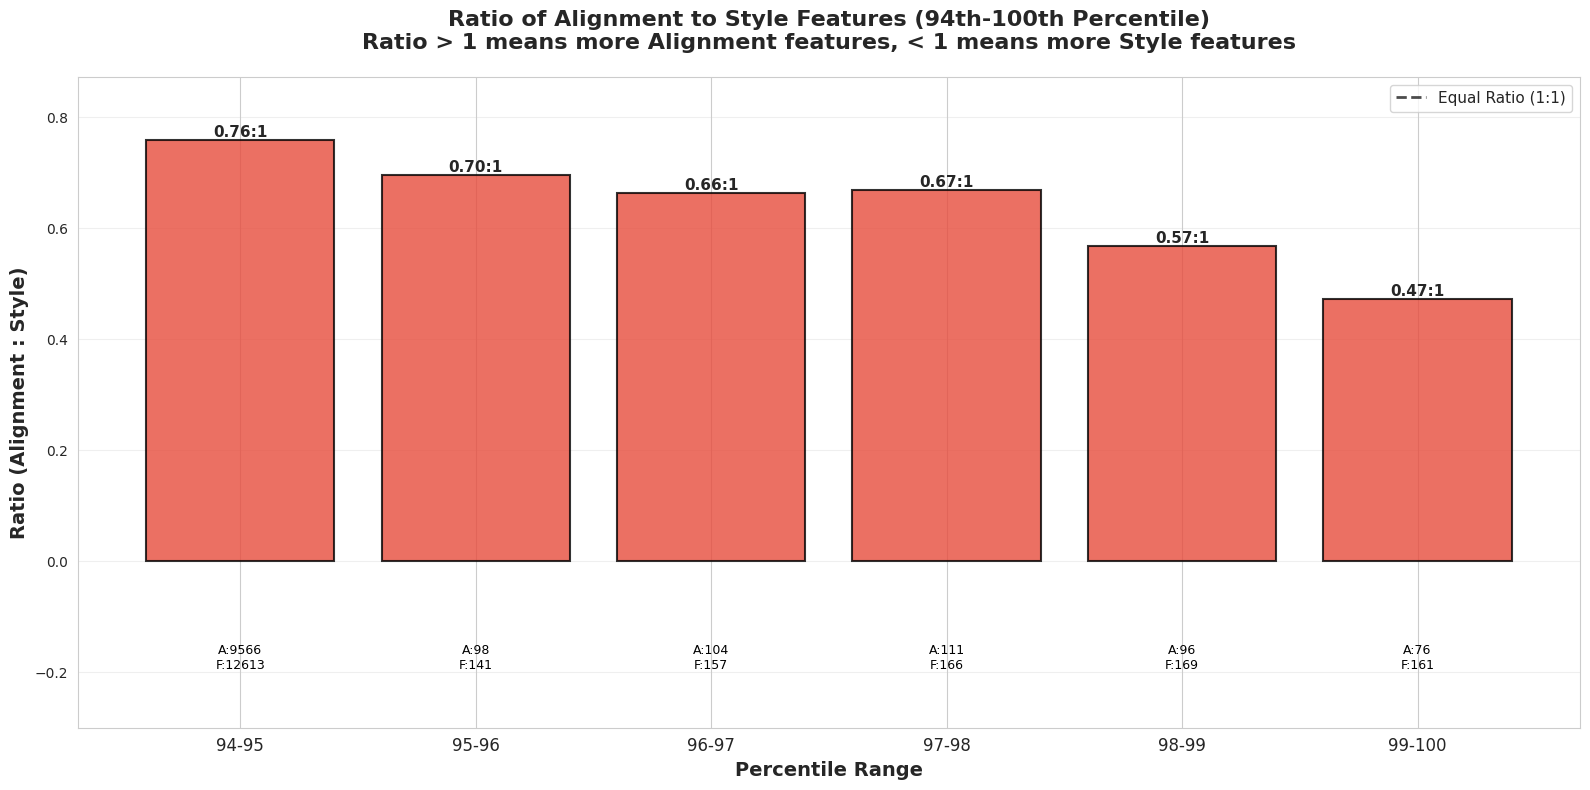


DETAILED BREAKDOWN: 94th-100th PERCENTILE (1% INTERVALS)

DIAGNOSTIC: First bin (94-95) data check:
  Alignment features in 94-95: 9566
  Style features in 94-95: 12613
  Ratio: 0.7584238484103702:1

Range        Alignment    Style        Total      Ratio (A:S)     Interpretation                
------------------------------------------------------------------------------------------------------------------------
94-95th       9566         12613        22179      0.758:1          Moderate Style advantage      
95-96th       98           141          239        0.695:1          Moderate Style advantage      
96-97th       104          157          261        0.662:1          Moderate Style advantage      
97-98th       111          166          277        0.669:1          Moderate Style advantage      
98-99th       96           169          265        0.568:1          Moderate Style advantage      
99-100th       76           161          237        0.472:1          Strong Style domi

In [77]:
# Create focused visualization for 94-100th percentile with 1% intervals
# Key change: Show RATIO of alignment to formatting in each bin instead of raw percentages

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Set style
sns.set_style("whitegrid")

# Define 1% ranges within 94-100
ranges = [(94, 95), (95, 96), (96, 97), (97, 98), (98, 99), (99, 100)]

alignment_data_top6 = alignment_top6['Percentile']
formatting_data_top6 = formatting_top6['Percentile']

# Calculate absolute counts and ratios for each range
alignment_abs_counts = []
formatting_abs_counts = []
ratios = []
range_labels = []

for low, high in ranges:
    align_count = ((alignment_data_top6 >= low) & (alignment_data_top6 < high)).sum()
    format_count = ((formatting_data_top6 >= low) & (formatting_data_top6 < high)).sum()
    
    alignment_abs_counts.append(align_count)
    formatting_abs_counts.append(format_count)
    
    # Calculate ratio (alignment / formatting)
    if format_count > 0:
        ratio = align_count / format_count
    else:
        ratio = align_count if align_count > 0 else 0
    ratios.append(ratio)
    range_labels.append(f'{low}-{high}')

# Create bar chart showing ratio
x_pos = np.arange(len(ranges))
colors_ratio = ['#27ae60' if r > 1 else '#e74c3c' if r < 1 else '#95a5a6' for r in ratios]

bars = ax.bar(x_pos, ratios, color=colors_ratio, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add horizontal line at ratio = 1 (equal representation)
ax.axhline(y=1, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Equal Ratio (1:1)')

# Add value labels on bars
for i, (ratio, align_c, format_c) in enumerate(zip(ratios, alignment_abs_counts, formatting_abs_counts)):
    # Ratio label on top of bar
    ax.text(i, ratio, f'{ratio:.2f}:1', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')
    # Count label below bar
    ax.text(i, -0.15, f'A:{align_c}\nF:{format_c}', ha='center', va='top', 
            fontsize=9, color='black')

ax.set_title('Ratio of Alignment to Style Features (94th-100th Percentile)\nRatio > 1 means more Alignment features, < 1 means more Style features', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Percentile Range', fontsize=14, fontweight='bold')
ax.set_ylabel('Ratio (Alignment : Style)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(range_labels, fontsize=12)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

# Adjust y-axis to accommodate labels below bars
y_min = -0.3
y_max = max(ratios) * 1.15
ax.set_ylim(y_min, y_max)

plt.tight_layout()
# Save high-quality versions
fig.savefig(plots_dir / 'alignment_style_ratio_94_100.pdf', dpi=300, bbox_inches='tight')
fig.savefig(plots_dir / 'alignment_style_ratio_94_100.png', dpi=300, bbox_inches='tight')
plt.show()

# Create detailed table
print("\n" + "=" * 120)
print("DETAILED BREAKDOWN: 94th-100th PERCENTILE (1% INTERVALS)")
print("=" * 120)

# Debug first bin
print(f"\nDIAGNOSTIC: First bin (94-95) data check:")
first_bin_align = ((alignment_data_top6 >= 94) & (alignment_data_top6 < 95)).sum()
first_bin_format = ((formatting_data_top6 >= 94) & (formatting_data_top6 < 95)).sum()
print(f"  Alignment features in 94-95: {first_bin_align}")
print(f"  Style features in 94-95: {first_bin_format}")
print(f"  Ratio: {first_bin_align/first_bin_format if first_bin_format > 0 else 'inf'}:1")

print(f"\n{'Range':<12} {'Alignment':<12} {'Style':<12} {'Total':<10} {'Ratio (A:S)':<15} {'Interpretation':<30}")
print("-" * 120)

for i, (low, high) in enumerate(ranges):
    align_c = alignment_abs_counts[i]
    format_c = formatting_abs_counts[i]
    total = align_c + format_c
    ratio = ratios[i]
    
    if ratio > 1.5:
        interpretation = "Strong Alignment dominance"
    elif ratio > 1.1:
        interpretation = "Moderate Alignment advantage"
    elif ratio > 0.9:
        interpretation = "Roughly balanced"
    elif ratio > 0.5:
        interpretation = "Moderate Style advantage"
    else:
        interpretation = "Strong Style dominance"
    
    print(f"{low}-{high}th{'':<6} {align_c:<12} {format_c:<12} {total:<10} {ratio:.3f}:1{'':<9} {interpretation:<30}")

print("-" * 120)
print(f"{'TOTAL':<12} {sum(alignment_abs_counts):<12} {sum(formatting_abs_counts):<12} {sum(alignment_abs_counts) + sum(formatting_abs_counts):<10} {sum(alignment_abs_counts)/sum(formatting_abs_counts):.3f}:1{'':<9} {'Overall average':<30}")
print("=" * 120)

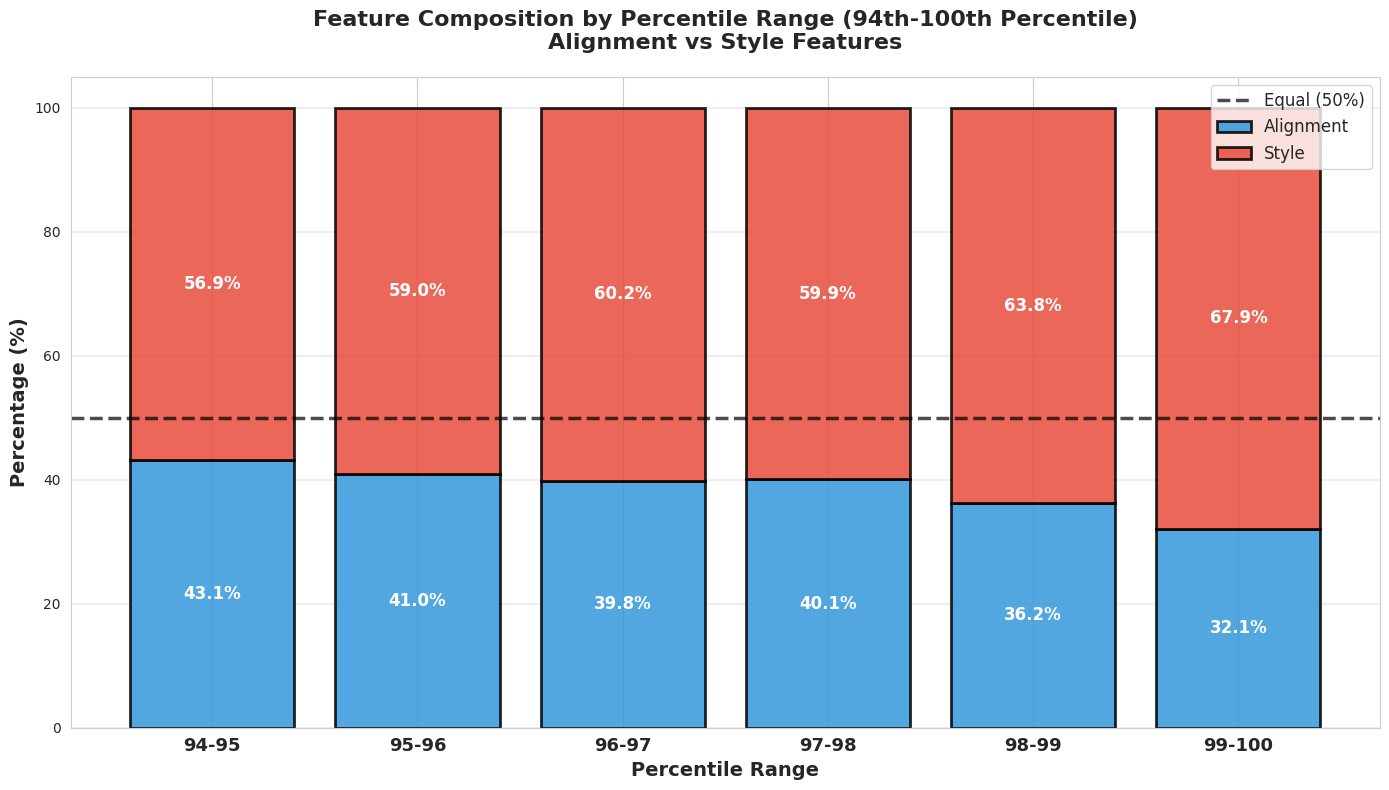


RATIO-BASED COMPARATIVE ANALYSIS

Ratio statistics:
  Mean ratio across all bins: 0.637:1
  Median ratio: 0.666:1
  Min ratio: 0.472:1 (in 99-100)
  Max ratio: 0.758:1 (in 94-95)

Bin dominance:
  Alignment-dominant bins (ratio > 1.1): 0/6
  Formatting-dominant bins (ratio < 0.9): 6/6
  Balanced bins (0.9 ≤ ratio ≤ 1.1): 0/6

Concentration in very top ranges (ratio analysis):
  97-100th percentile ratio: 0.571:1
  99-100th percentile ratio: 0.472:1

Overall summary for 94-100th percentile:
  Total alignment features: 10051
  Total style features: 13407
  Overall ratio: 0.750:1
  Alignment comprises: 42.8% of top 6%
  Style comprises: 57.2% of top 6%


In [78]:
# Focus on percentage composition visualization (the most informative)
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

x_pos = np.arange(len(ranges))

# Calculate percentages
alignment_pcts = [a / (a + f) * 100 if (a + f) > 0 else 0 
                  for a, f in zip(alignment_abs_counts, formatting_abs_counts)]
formatting_pcts = [f / (a + f) * 100 if (a + f) > 0 else 0 
                   for a, f in zip(alignment_abs_counts, formatting_abs_counts)]

# Create stacked bar chart
ax.bar(x_pos, alignment_pcts, label='Alignment', 
       color='#3498db', alpha=0.85, edgecolor='black', linewidth=2)
ax.bar(x_pos, formatting_pcts, bottom=alignment_pcts, label='Style',
       color='#e74c3c', alpha=0.85, edgecolor='black', linewidth=2)

# Add 50% reference line
ax.axhline(y=50, color='black', linestyle='--', linewidth=2.5, alpha=0.7, label='Equal (50%)')

# Add percentage labels with better visibility
for i, (a_pct, f_pct) in enumerate(zip(alignment_pcts, formatting_pcts)):
    # Alignment percentage
    if a_pct > 8:
        ax.text(i, a_pct/2, f'{a_pct:.1f}%', ha='center', va='center', 
                fontsize=12, fontweight='bold', color='white')
    # Formatting percentage
    if f_pct > 8:
        ax.text(i, a_pct + f_pct/2, f'{f_pct:.1f}%', ha='center', va='center', 
                fontsize=12, fontweight='bold', color='white')

ax.set_title('Feature Composition by Percentile Range (94th-100th Percentile)\nAlignment vs Style Features', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Percentile Range', fontsize=14, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{low}-{high}' for low, high in ranges], fontsize=13, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3, axis='y', linewidth=1.5)
ax.set_ylim(0, 105)

plt.tight_layout()
# Save high-quality versions
fig.savefig(plots_dir / 'alignment_style_composition_94_100.pdf', dpi=300, bbox_inches='tight')
fig.savefig(plots_dir / 'alignment_style_composition_94_100.png', dpi=300, bbox_inches='tight')
plt.show()

# Print comparative analysis with ratio focus
print("\n" + "=" * 100)
print("RATIO-BASED COMPARATIVE ANALYSIS")
print("=" * 100)

print(f"\nRatio statistics:")
print(f"  Mean ratio across all bins: {np.mean(ratios):.3f}:1")
print(f"  Median ratio: {np.median(ratios):.3f}:1")
print(f"  Min ratio: {np.min(ratios):.3f}:1 (in {range_labels[np.argmin(ratios)]})")
print(f"  Max ratio: {np.max(ratios):.3f}:1 (in {range_labels[np.argmax(ratios)]})")

print(f"\nBin dominance:")
alignment_dominant = sum(1 for r in ratios if r > 1.1)
formatting_dominant = sum(1 for r in ratios if r < 0.9)
balanced = sum(1 for r in ratios if 0.9 <= r <= 1.1)
print(f"  Alignment-dominant bins (ratio > 1.1): {alignment_dominant}/{len(ranges)}")
print(f"  Formatting-dominant bins (ratio < 0.9): {formatting_dominant}/{len(ranges)}")
print(f"  Balanced bins (0.9 ≤ ratio ≤ 1.1): {balanced}/{len(ranges)}")

print(f"\nConcentration in very top ranges (ratio analysis):")
top_3_ratio = sum(alignment_abs_counts[3:]) / sum(formatting_abs_counts[3:]) if sum(formatting_abs_counts[3:]) > 0 else float('inf')
top_1_ratio = alignment_abs_counts[5] / formatting_abs_counts[5] if formatting_abs_counts[5] > 0 else float('inf')
print(f"  97-100th percentile ratio: {top_3_ratio:.3f}:1")
print(f"  99-100th percentile ratio: {top_1_ratio:.3f}:1")

print(f"\nOverall summary for 94-100th percentile:")
total_alignment = sum(alignment_abs_counts)
total_formatting = sum(formatting_abs_counts)
overall_ratio = total_alignment / total_formatting if total_formatting > 0 else float('inf')
print(f"  Total alignment features: {total_alignment}")
print(f"  Total style features: {total_formatting}")
print(f"  Overall ratio: {overall_ratio:.3f}:1")
print(f"  Alignment comprises: {total_alignment/(total_alignment+total_formatting)*100:.1f}% of top 6%")
print(f"  Style comprises: {total_formatting/(total_alignment+total_formatting)*100:.1f}% of top 6%")

Unrelated percentiles:   0%|          | 0/54393 [00:00<?, ?it/s]

Unrelated percentiles: 100%|██████████| 54393/54393 [00:02<00:00, 21126.78it/s]



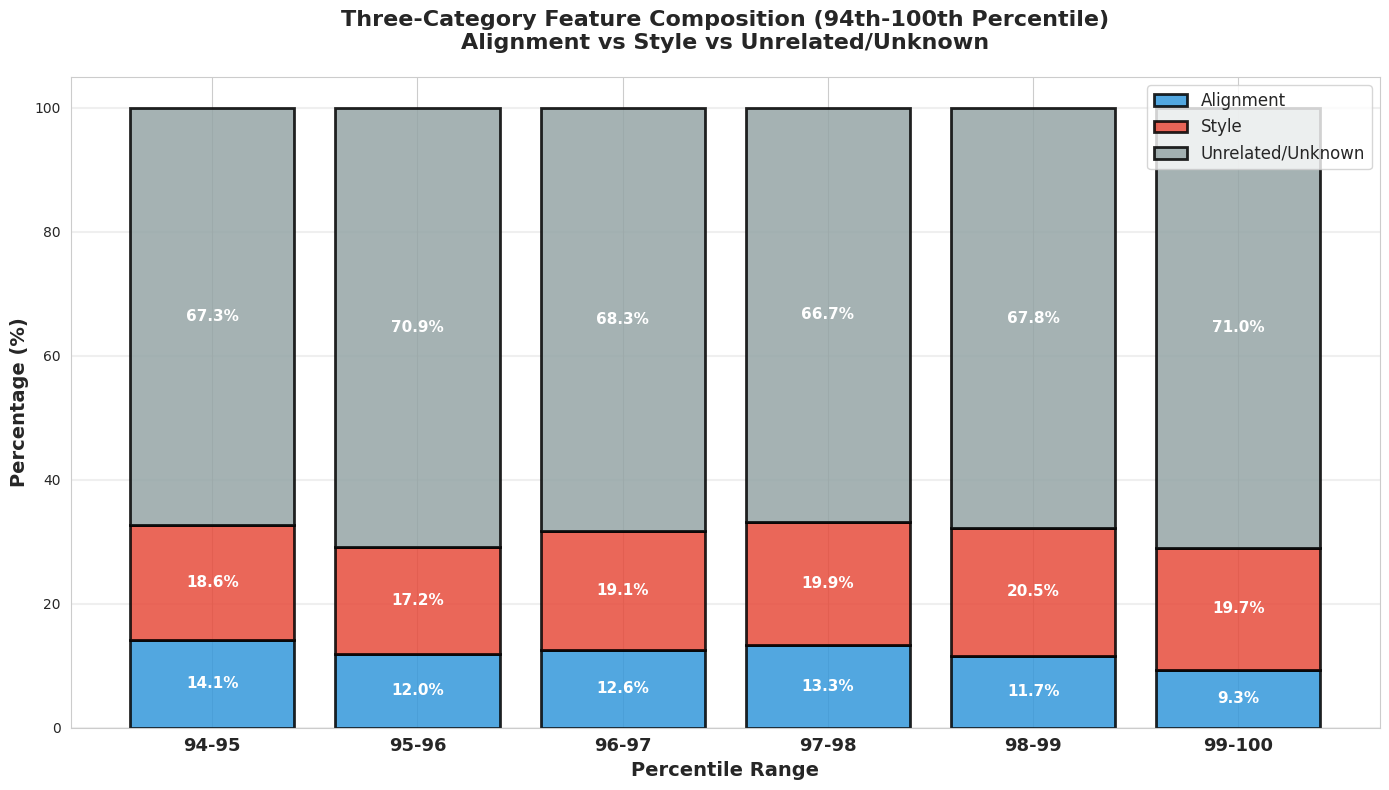


THREE-CATEGORY BREAKDOWN: 94th-100th PERCENTILE

Range        Alignment    Style        Unrelated    Total      A%       S%       U%      
----------------------------------------------------------------------------------------------------------------------------------
94-95th       9566         12613        45565        67744      14.1   % 18.6   % 67.3   %
95-96th       98           141          581          820        12.0   % 17.2   % 70.9   %
96-97th       104          157          563          824        12.6   % 19.1   % 68.3   %
97-98th       111          166          556          833        13.3   % 19.9   % 66.7   %
98-99th       96           169          559          824        11.7   % 20.5   % 67.8   %
99-100th       76           161          579          816        9.3    % 19.7   % 71.0   %
----------------------------------------------------------------------------------------------------------------------------------
TOTAL        10051        13407        48403       

In [79]:
# Create a three-category composition visualization including unrelated features
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

x_pos = np.arange(len(ranges))

# Get all features (including unrelated) in the 94-100 percentile range
all_alignment_features = [f for f in alignment_features if f['classification'] == 'related']
all_formatting_features = [f for f in formatting_features if f['classification'] == 'related']

# Calculate percentiles for unrelated features from both datasets
unrelated_alignment_features = [f for f in alignment_features if f['classification'] != 'related']
unrelated_formatting_features = [f for f in formatting_features if f['classification'] != 'related']

# For unrelated features, we'll use the alignment dataset as the base (they should be the same features)
unrelated_percentile_map = {}
for feature in tqdm(unrelated_alignment_features, desc="Unrelated percentiles"):
    feature_value = feature['mean_activation']
    count_above = np.sum(all_alignment_values >= feature_value)
    percentile = (count_above / len(all_alignment_values)) * 100
    unrelated_percentile_map[feature['feature_index']] = percentile

unrelated_percentiles = list(unrelated_percentile_map.values())
unrelated_percentile_df = pd.DataFrame({
    'Percentile': unrelated_percentiles,
    'Feature Type': 'Unrelated'
})

# Filter unrelated features for 94-100 percentile
unrelated_top6 = unrelated_percentile_df[unrelated_percentile_df['Percentile'] >= 94].copy()
unrelated_data_top6 = unrelated_top6['Percentile']

# Calculate counts for all three categories
alignment_abs_counts_3cat = []
formatting_abs_counts_3cat = []
unrelated_abs_counts_3cat = []

for low, high in ranges:
    align_count = ((alignment_data_top6 >= low) & (alignment_data_top6 < high)).sum()
    format_count = ((formatting_data_top6 >= low) & (formatting_data_top6 < high)).sum()
    unrelated_count = ((unrelated_data_top6 >= low) & (unrelated_data_top6 < high)).sum()
    
    alignment_abs_counts_3cat.append(align_count)
    formatting_abs_counts_3cat.append(format_count)
    unrelated_abs_counts_3cat.append(unrelated_count)

# Calculate percentages for three categories
alignment_pcts_3cat = []
formatting_pcts_3cat = []
unrelated_pcts_3cat = []

for a, f, u in zip(alignment_abs_counts_3cat, formatting_abs_counts_3cat, unrelated_abs_counts_3cat):
    total = a + f + u
    if total > 0:
        alignment_pcts_3cat.append(a / total * 100)
        formatting_pcts_3cat.append(f / total * 100)
        unrelated_pcts_3cat.append(u / total * 100)
    else:
        alignment_pcts_3cat.append(0)
        formatting_pcts_3cat.append(0)
        unrelated_pcts_3cat.append(0)

# Create stacked bar chart with three categories
ax.bar(x_pos, alignment_pcts_3cat, label='Alignment', 
       color='#3498db', alpha=0.85, edgecolor='black', linewidth=2)
ax.bar(x_pos, formatting_pcts_3cat, bottom=alignment_pcts_3cat, label='Style',
       color='#e74c3c', alpha=0.85, edgecolor='black', linewidth=2)
ax.bar(x_pos, unrelated_pcts_3cat, 
       bottom=[a + f for a, f in zip(alignment_pcts_3cat, formatting_pcts_3cat)], 
       label='Unrelated/Unknown',
       color='#95a5a6', alpha=0.85, edgecolor='black', linewidth=2)

# Add percentage labels with better visibility
for i, (a_pct, f_pct, u_pct) in enumerate(zip(alignment_pcts_3cat, formatting_pcts_3cat, unrelated_pcts_3cat)):
    # Alignment percentage
    if a_pct > 8:
        ax.text(i, a_pct/2, f'{a_pct:.1f}%', ha='center', va='center', 
                fontsize=11, fontweight='bold', color='white')
    # Formatting percentage
    if f_pct > 8:
        ax.text(i, a_pct + f_pct/2, f'{f_pct:.1f}%', ha='center', va='center', 
                fontsize=11, fontweight='bold', color='white')
    # Unrelated percentage
    if u_pct > 8:
        ax.text(i, a_pct + f_pct + u_pct/2, f'{u_pct:.1f}%', ha='center', va='center', 
                fontsize=11, fontweight='bold', color='white')

ax.set_title('Three-Category Feature Composition (94th-100th Percentile)\nAlignment vs Style vs Unrelated/Unknown', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Percentile Range', fontsize=14, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{low}-{high}' for low, high in ranges], fontsize=13, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3, axis='y', linewidth=1.5)
ax.set_ylim(0, 105)

plt.tight_layout()
# Save high-quality versions
fig.savefig(plots_dir / 'three_category_composition_94_100.pdf', dpi=300, bbox_inches='tight')
fig.savefig(plots_dir / 'three_category_composition_94_100.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed breakdown
print("\n" + "=" * 130)
print("THREE-CATEGORY BREAKDOWN: 94th-100th PERCENTILE")
print("=" * 130)

print(f"\n{'Range':<12} {'Alignment':<12} {'Style':<12} {'Unrelated':<12} {'Total':<10} {'A%':<8} {'S%':<8} {'U%':<8}")
print("-" * 130)

for i, (low, high) in enumerate(ranges):
    align_c = alignment_abs_counts_3cat[i]
    format_c = formatting_abs_counts_3cat[i]
    unrelated_c = unrelated_abs_counts_3cat[i]
    total = align_c + format_c + unrelated_c
    
    a_pct = alignment_pcts_3cat[i]
    f_pct = formatting_pcts_3cat[i]
    u_pct = unrelated_pcts_3cat[i]
    
    print(f"{low}-{high}th{'':<6} {align_c:<12} {format_c:<12} {unrelated_c:<12} {total:<10} {a_pct:<7.1f}% {f_pct:<7.1f}% {u_pct:<7.1f}%")

print("-" * 130)
total_align = sum(alignment_abs_counts_3cat)
total_format = sum(formatting_abs_counts_3cat)
total_unrelated = sum(unrelated_abs_counts_3cat)
grand_total = total_align + total_format + total_unrelated

print(f"{'TOTAL':<12} {total_align:<12} {total_format:<12} {total_unrelated:<12} {grand_total:<10} {total_align/grand_total*100:<7.1f}% {total_format/grand_total*100:<7.1f}% {total_unrelated/grand_total*100:<7.1f}%")
print("=" * 130)

print(f"\n📊 THREE-CATEGORY SUMMARY:")
print(f"   Alignment features: {total_align:,} ({total_align/grand_total*100:.1f}%)")
print(f"   Style features: {total_format:,} ({total_format/grand_total*100:.1f}%)")
print(f"   Unrelated/Unknown features: {total_unrelated:,} ({total_unrelated/grand_total*100:.1f}%)")
print(f"   Total features in 94-100th percentile: {grand_total:,}")

In [80]:
# Save all analysis results to CSV files
most_fired_output_path = base_path / 'outputs' / 'top_10_most_fired_features.csv'
most_active_output_path = base_path / 'outputs' / 'top_10_most_active_features.csv'
least_active_output_path = base_path / 'outputs' / 'bottom_10_least_active_features.csv'
overall_summary_output_path = base_path / 'outputs' / 'overall_feature_classification_summary.csv'

most_fired_df.to_csv(most_fired_output_path, index=False)
most_active_df.to_csv(most_active_output_path, index=False)
least_active_df.to_csv(least_active_output_path, index=False)
overall_summary_df.to_csv(overall_summary_output_path, index=False)

print(f"✅ Most fired results saved to: {most_fired_output_path}")
print(f"✅ Most active results saved to: {most_active_output_path}")
print(f"✅ Least active results saved to: {least_active_output_path}")
print(f"✅ Overall summary saved to: {overall_summary_output_path}")

# Create a final comprehensive summary
print("\n" + "="*120)
print("FINAL SUMMARY")
print("="*120)
print("\nTOP 10 MOST FIRED FEATURES:")
print(f"  - Based on usage count across all positions")
print(f"  - Total features analyzed: {len(alignment_features)}")

print("\nTOP 10 MOST ACTIVE FEATURES:")
print(f"  - Based on highest mean activation values")

print("\nBOTTOM 10 LEAST ACTIVE FEATURES:")
print(f"  - Based on most negative mean activation values")

print("\nOVERALL FEATURE ANALYSIS (ALL FEATURES):")
print(f"  - Alignment-related features: {len(alignment_related_features)} features ({len(alignment_related_features)/len(alignment_features)*100:.1f}%)")
print(f"    Average percentile rank: {alignment_avg_percentile:.2f}%")
print(f"  - Formatting-related features: {len(formatting_related_features)} features ({len(formatting_related_features)/len(formatting_features)*100:.1f}%)")
print(f"    Average percentile rank: {formatting_avg_percentile:.2f}%")


✅ Most fired results saved to: ../outputs/top_10_most_fired_features.csv
✅ Most active results saved to: ../outputs/top_10_most_active_features.csv
✅ Least active results saved to: ../outputs/bottom_10_least_active_features.csv
✅ Overall summary saved to: ../outputs/overall_feature_classification_summary.csv

FINAL SUMMARY

TOP 10 MOST FIRED FEATURES:
  - Based on usage count across all positions
  - Total features analyzed: 65536

TOP 10 MOST ACTIVE FEATURES:
  - Based on highest mean activation values

BOTTOM 10 LEAST ACTIVE FEATURES:
  - Based on most negative mean activation values

OVERALL FEATURE ANALYSIS (ALL FEATURES):
  - Alignment-related features: 11143 features (17.0%)
    Average percentile rank: 85.80%
  - Formatting-related features: 15391 features (23.5%)
    Average percentile rank: 82.94%


In [81]:
# Summary of saved plots
print("\n" + "="*120)
print("SAVED PLOTS")
print("="*120)
print(f"\nAll plots have been saved to: {plots_dir.absolute()}")
print("\nHigh-resolution versions (300 DPI) saved as both PDF and PNG:")
print("  1. overall_percentile_distribution.pdf / .png")
print("  2. density_vs_absolute_counts.pdf / .png")
print("  3. alignment_style_ratio_94_100.pdf / .png")
print("  4. alignment_style_composition_94_100.pdf / .png")
print("  5. three_category_composition_94_100.pdf / .png")
print("\n✅ All visualizations saved successfully!")
print("="*120)


SAVED PLOTS

All plots have been saved to: /lambda/nfs/fsrl/feature-steering-RL/notebooks/plots

High-resolution versions (300 DPI) saved as both PDF and PNG:
  1. overall_percentile_distribution.pdf / .png
  2. density_vs_absolute_counts.pdf / .png
  3. alignment_style_ratio_94_100.pdf / .png
  4. alignment_style_composition_94_100.pdf / .png
  5. three_category_composition_94_100.pdf / .png

✅ All visualizations saved successfully!
